## Work
1. 請自行定義一個 loss function, 為 0.3 * focal loss + 0.7 cross-entropy，訓練並比較結果


In [14]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

train, test = keras.datasets.cifar10.load_data()

## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [15]:
from keras.layers import Input, Dense, BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):    
    """
    Build your own model
    """
    input_layer = Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
## 超參數設定
learning_rate = 1e-2
epochs = 50
batch_size = 256

In [17]:
import tensorflow as tf
import keras.backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

"""
TO DO:
Write your combined loss
"""
def combined_loss(gamma=2., alpha=4., ce_weights=0.7, fcl_weights=0.3):
    """Define the customized loss."""
    gamma = float(gamma)
    alpha = float(alpha)
    def ce_focal_loss(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        """
        epsilon = 1e-8
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        
        ce_loss = keras.losses.categorical_crossentropy(y_true, y_pred)
        return fcl_weights * tf.reduce_mean(reduced_fl) + ce_weights * ce_loss
    return ce_focal_loss

ce_weights_list = [0.0, 0.3, 0.5, 0.7, 1]

In [19]:
results = {}
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.2, min_lr=1e-12, monitor='val_loss', patience=2, verbose=1)
for i, ce_w in enumerate(ce_weights_list):
    print(f'ce_weights = {ce_w}, fcl_weights = {1-ce_w}')

    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=learning_rate, nesterov=True, momentum=0.95)
    model.compile(loss=combined_loss(ce_weights=ce_w, fcl_weights=1-ce_w), metrics=["accuracy"], optimizer=optimizer)
    """
    TO DO:
    Compile your model with customized loss
    """

    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), shuffle=True, 
              callbacks=[earlystop, reduce_lr])
    
    # Collect results
    name_tag = f'ce_weights = {ce_w}, fcl_weights = {1-ce_w}'
    results[name_tag] = {'train-loss': model.history.history["loss"], 'valid-loss': model.history.history["val_loss"], 
                         'train-acc': model.history.history["accuracy"], 'valid-acc': model.history.history["val_accuracy"]}

ce_weights = 0.0, fcl_weights = 1.0
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_10 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_11 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_12 

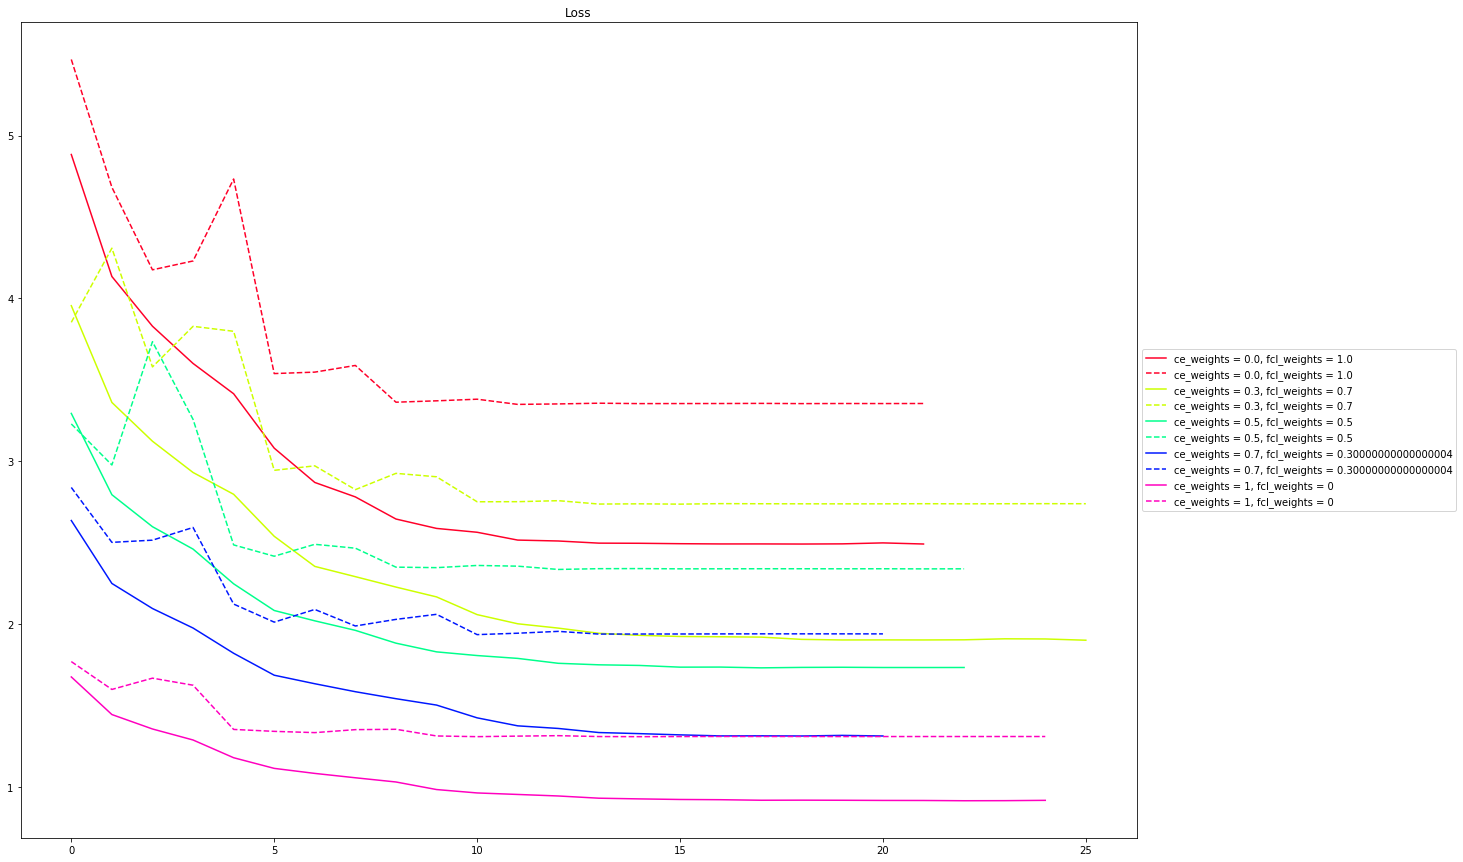

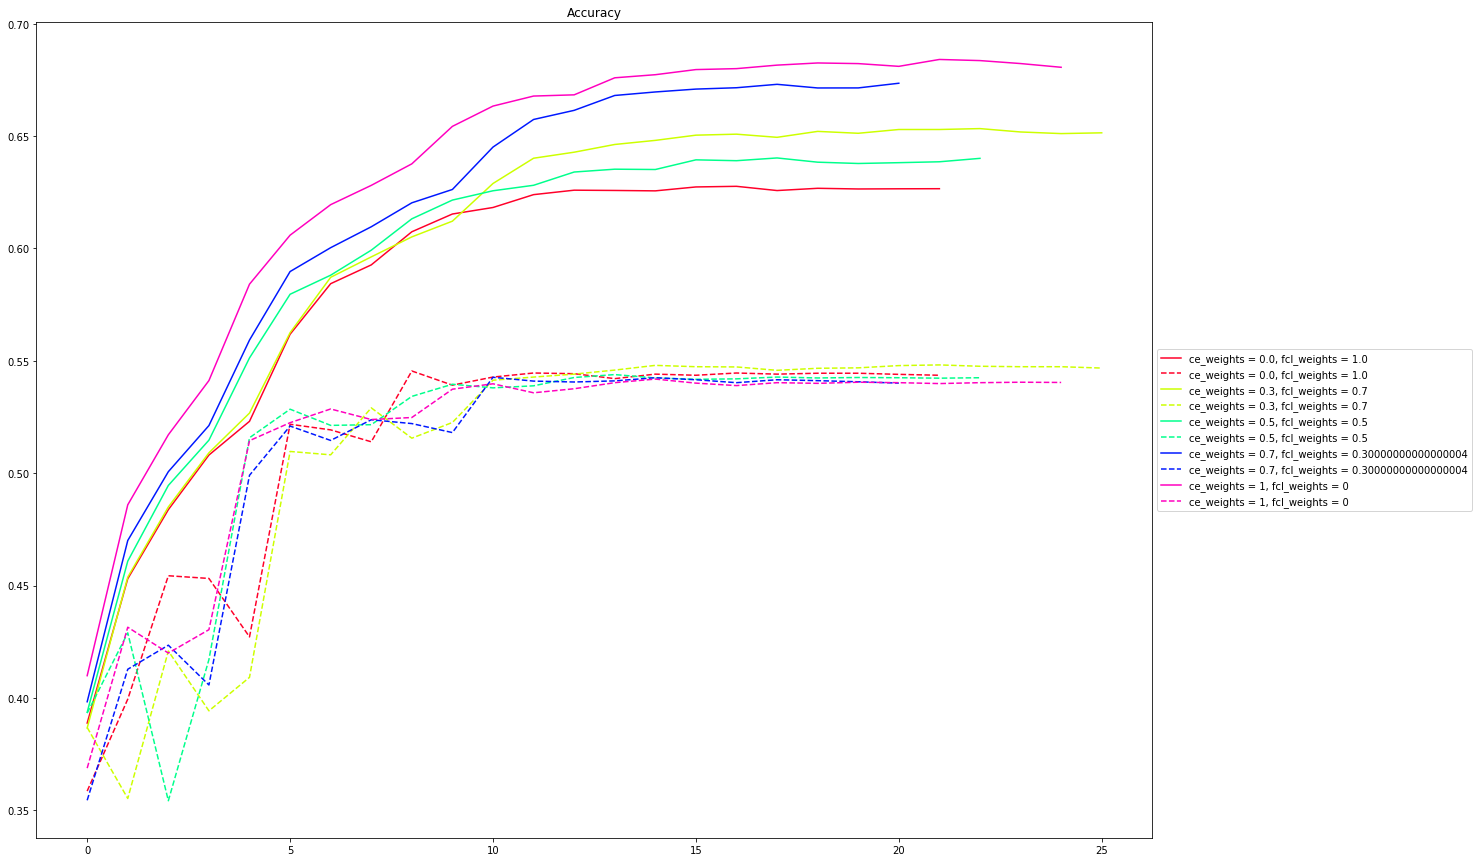

In [20]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
num_colors = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=num_colors-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(num_colors)]

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(20, 15))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()